# Interatomic force field (IFF) optimization for W-based metal alloys

Author: Lukas Vlcek

Start Date: 2018-04-22

In [1]:
from datetime import datetime ; print('Last update:', datetime.now())

Last update: 2018-07-25 21:53:17.329834


# Table of Contents

* [1. Introduction](#1.-Introduction)
* [2. Theoretical background](#2.-Theoretical-background)
    * [2.1 Model definition](#2.1-Model-definition)
    * [2.2 Optimization approach](#2.2-Optimization-approach)
        * [2.2.1 Perturbation technique](#2.2.1-Perturbation-technique)
        * [2.2.2 Statistical distance loss function](#2.2.2-Statistical-distance-loss-function)
    * [2.3 Target data](#2.3-Target-data)
    * [2.4 Simulation details](#2.4-Simulation-details)
* [3. Optimization](#3.-Optimization)

**Notebook setup**

In [37]:
# Import libraries
%matplotlib inline
import os
import glob
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
import h5py
from itertools import product
from scipy.optimize import fmin

# Paths to important directories
pot_path = '../sim/potentials'
target_raw = '../data/target_raw'
target_proc = '../data/target_processed'
working = '../data/working'

## 1. Introduction

**Goal:** Optimize EAM potential for W using the functional form of Bonny et al. (2017), and target data from Marinica et al. (2013) and German. Show that using this simplified EAM form we can develop a more predictive model of W compared to EAM2 model of Marinica.

## 2. Theoretical background

### 2.1 Model definition

**Equilibrium potential**

Energy of an N-particle configuration

$$ E = \sum_{i=1}^N \left[ \sum_{j>i}^N V_{t_it_j}\left(r_{ij}\right) + F_{t_i}\left(\rho_i\right) \right] $$

Here $V_{t_it_j}$ is pair interaction between atom types $t_i$ and $t_j$ at distance $r_{ij}$ defined as

$$ V_{t_it_j}\left(r_{ij}\right) = \sum_{k=1}^{K}\left[a_k\left(r_k - r_{ij}\right)^3\Theta\left(r_k - r_{ij}\right)\right]\ $$

where $\Theta$ is Heaviside step function.
$F_{t_i}$ is the manybody embedding function

$$ F_{t_i}(\rho_i) = A_{t_i}\sqrt{\rho_i} + B_{t_i}\rho + C_{t_i}\rho^2 $$

where $\rho_i$ effective electron density 

$$ \rho_i = \sum_{j\ne i}^N \phi_{t_j}\left(r_{ij}\right) $$

and $\phi$ is cohesive potential

$$ \phi\left(r_{ij}\right) = D_{t_j}\left(r_c - r_{ij}\right)^3\Theta\left(r_c - r_{ij}\right) $$

In [467]:
# Define the equilibrium EAM functions (to be optimized)

# Pair potential (cubic splines). Parameters: distance (r), spline parameters (aa), spline nodes (cc)
V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Embedding function. Parameters: electronic density (d), coefficients for 1/2, 1, and 2 powers of density
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

# Cohesive potential (cubic splines - same form as V)
phi = V

**Core and transition potential for short and intermediate distances**

In [4]:
# Define the core and transition parts of the potential (kept constant)
def u_core(r, za=74, zb=74):
    """Repulsive potential of the atomic cores. Default atomic numbers for W"""
    qe_sq = 14.3992 # squared electron charge  
    rs = 0.4683766/(za**(2/3) + zb**(2/3))**0.5
    x = r/rs
    u  = 0.1818*np.exp(-3.2*x)
    u += 0.5099*np.exp(-0.9423*x)
    u += 0.2802*np.exp(-0.4029*x)
    u += 0.02817*np.exp(-0.2016*x)
    u *= za*zb*qe_sq/r
    return u

def u_trans(r, unucl, ueq, ri=1.0, ro=2.0):
    """Transition between the core and equillibrium potentials"""
    if r < ri:
        return unucl
    elif r < ro:
        x = (ro + ri - 2*r)/(ro - ri)
        eta = 3/16*x**5 - 5/8*x**3 + 15/16*x + 1/2
        return ueq + eta*(unucl - ueq)
    else:
        return ueq    

### 2.2 Optimization approach

#### 2.2.1 Perturbation technique

**EAM sufficient statistics**

**Energy of a configuration**

Energy of an N-particle configuration

$$ E_{pair} = \sum_{k=1}^{K}a_k\sum_{i=1}^N \sum_{j>i}^N \left[\left(r_k - r_{ij}\right)^3\Theta\left(r_k - r_{ij}\right)\right]\ = \sum_{k=1}^{K}a_kv_k $$

$$ E_{manybody} = b_1\sum_{i=1}^N\sqrt{\sum_{j\ne i}^N \left[\left(r_c - r_{ij}\right)^3\Theta\left(r_c - r_{ij}\right)\right]} + b_2 \sum_{i=1}^N \left( \sum_{j\ne i}^N \left[\left(r_c - r_{ij}\right)^3\Theta\left(r_c - r_{ij}\right)\right] \right)^2 = b_1m_1 + b_2m_2$$

**Similar for evaluating forces on each atom... **

During optimization, collect statistics $v_k$ and $b_k$ for each configuration and calculate its energy by multiplying them by model parameters $a_k$ and $b_k$.

In [829]:
# pair distances between system atoms
def pair_dist(xyz, box):
    """
    Calculates nearest image pair distances between all atoms in xyz array.
    Parameters
    -----------
    xyz : numpy array
          particle x, y, z coordinates
    box : scalar or numpy array
          simulation box dimensions/shape
    Returns
    -------
    rr  : (natom, natom) numpy array of pair distances
    rx  : (natom, natom, 3) numpy array of pair distance coordinates
    """

    n_atom = xyz.shape[0] # number of atoms in a configuration
    rr = np.empty((n_atom, n_atom), dtype=float)
    rx = np.empty((n_atom, n_atom, 3), dtype=float)

    for i, pa in enumerate(xyz):
        for j, pb in enumerate(xyz):
            dp = pa - pb
            dp = np.where(dp < -0.5*box, dp + box, dp)
            dp = np.where(dp >  0.5*box, dp - box, dp)
            rr[i,j] = np.sum(dp*dp)**0.5
            rx[i,j] = dp

    return rr, rx

In [6]:
def get_stats_EAM(rr, rx, sc):
    """
    Takes atom pair distances and calculates sufficeint statistics needed
    for the parameterization of a cubic spline-based EAM model by Bonny et al. (2017).
    
    Parameters
    ----------
    rr : numpy array
         set of pair distances
    rx : numpy array
         set of pair distance coordinates
    sc : python list
         spline nodes
         
    Returns
    -------
    ar, a1, a2 : numpy arrays (len(sc))
                 atom energy-related statistics
                 el_density**0.5, el_density, el_density**2
    br, b1, b2 : numpy arrays (len(sc), natoms, 3 coordinates)
                 atom force-related statistics (gradients of energy)
                 grad(el_density**0.5), grad(el_density), grad(el_density**2)
    """
    
    # number of atoms in configuration
    n_atom = rr.shape[0]
    
    # energy-related statistics
    aa = np.empty((n_atom), dtype=float)
    ar = np.zeros((len(sc)), dtype=float)
    a1 = np.zeros_like(ar)
    a2 = np.zeros_like(ar)
    
    # force-related statistics
    br = np.zeros((len(sc), n_atom, 3), dtype=float)
    b1 = np.zeros_like(br)
    b2 = np.zeros_like(br)
    zero3 = np.zeros((3), dtype=float)

    # cycle over spline nodes
    for ks, rc in enumerate(sc):
        
        # cycle over atoms
        for i in range(n_atom):
            
            # sum electronic density over all neighbors of i within rc
            aa[i] = sum([(rc - r)**3 for r in rr[i] if (r < rc and r > 0.01)])

            # if el. density larger than zero, calculate force statistics
            if aa[i] > 0.0:
                
                # precompute a list of recurring values for force statistics
                ff = [1.5*(rc - r)**2*x/r if (r > 0.01 and r < rc) else zero3 for r, x in zip(rr[i], rx[i])]
                
                # sum contributions to force statistics from all neighbors of i
                b1[ks, i] = sum([2*f       for f in ff])
                br[ks, i] = sum([ -f/np.sqrt(aa[i]) for f in ff])
                b2[ks, i] = sum([4*f*aa[i] for f in ff])

        # sum contributions to energy statistics for a given spline node
        ar[ks] = np.sum(np.sqrt(aa))
        a1[ks] = np.sum(aa)
        a2[ks] = np.sum(aa**2)
        
    return a1, ar, a2, b1, br, b2

**EAM configurational energy based on sufficient statistics and model parameters**

In [659]:
def utot_EAM(params, ustats):
    """
    Calculates configurational energy from EAM sufficient statistics and model parameters

    Parameters
    ----------
    params : list of lists and floats
             EAM interaction parameters (spline coefficients array and embedding function parameters)
    ustats : list of lists and floats
             Sufficient statistics for a trajectory of configurations

    Returns
    -------
    u_total: float
             total configurational energy (sum of pair and manybody interactions) for trajectory of configurations
    """

    n_sample = len(ustats)

    # pair interactions from array of spline coefficeints and corresponding statistic
    u_pair = np.array([sum([a*s for a, s in zip(params[2:], ustats[i][2,:])]) for i in range(n_sample)])

    # manybody interactions from embedding function parameters and corresponding statistics
    u_many = np.array([params[0]*ustats[i][0, -1] + params[1]*ustats[i][1, -1] for i in range(n_sample)])

    u_total = 0.5*u_pair + u_many

    return u_total

In [660]:
def ftot_EAM(params, fstats):
    """
    Calculates configurational energy from EAM sufficient statistics and model parameters

    Parameters
    ----------
    params : list of lists and floats
             EAM interaction parameters (spline coefficients array and embedding function parameters)
    fstats : list of lists and floats
             Sufficient statistics

    Returns
    -------
    f_total: float
             total configurational energy (sum of pair and manybody interactions)
    """

    # number of samples and atoms
    n_sample = len(fstats)
    
    
    # cycle over samples
    f_total = []
    for i in range(n_sample):

        # pair interactions from array of spline coefficeints and corresponding statistic
        f_pair = sum([p*s for p, s in zip(params[2:], fstats[i][2,:])]) 

        # manybody interactions from embedding function parameters and corresponding statistics
        f_many = params[0]*fstats[i][0,-1] + params[1]*fstats[i][1, -1]
        
        n_atom = fstats[i][0,0].shape[0]
        # Create a 6N + 1 array of 0, f, and -f
        fx = np.zeros((6*n_atom + 1), dtype=float)
        fx[1:3*n_atom+1] = 0.5*f_pair.flatten() + f_many.flatten()
        fx[3*n_atom+1:] = -fx[1:3*n_atom+1]
        #print('natom', n_atom, type(f_pair), type(f_many), f_pair.shape, f_many.shape)
 
        f_total.append(fx)
        
    return np.array(f_total)

#### 2.2.2 Statistical distance loss function

**Loss function based on configurational energies and forces**

In [781]:
def sd2_loss(params, stats, targets, fopt=False):
    """
    Calculates squared statistical distance loss function for configurational energies and forces.

    Parameters
    ----------
    params : list of lists and floats
             EAM interaction parameters (spline coefficients array and embedding function parameters)
    stats  : list of lists and floats
             Sufficient statistics
    targets: list of lists and floats
             target energies and forces

    Returns
    -------
    sd2, sd2f: float
               squared statistical distances between model and target (energy and force-based)
    """

    # apply bounds on parametes
    #p = np.where(p < -1.0, -1.0, p)
    #p = np.where(p >  1.0,  1.0, p)

    # cycle over target system trajectories and statistics to determine SD
    sd2 = sd2f = 0.0
    for targ, stat in zip(targets, stats):

        beta = np.mean(targ['beta']) # system inverse temperature
        u_targ = np.array(targ['energy']) # target energies
        u_stat = stat['energy'] # energy statistics
        n_sample = len(u_targ)
        w = targ.get('weight', 1.0)
        #w = 1.0
        #print('inside', beta, u_targ)

        # energy diference array for a given target trajectory
        uuu = beta*(utot_EAM(params, u_stat) - u_targ) # array(n_sample)
        uuu -= np.mean(uuu)
        eee = np.exp(-uuu)
        
        #print('opti', list(np.array(utot_EAM(params, u_stat))))
        #print('targ', list(u_targ))

        # are forces available?
        if (not fopt) and ('forcesx' not in targ):

            # energy-based free energy difference and statistical distance
            ge = -np.log(np.mean(eee))   # free energy difference (shifted)
            cb = np.mean(np.exp(-0.5*(uuu - ge))) # Bhattacharyya coefficient
            sd2 += w*np.arccos(cb)**2              # statistical distance

        else:

            betad = beta*0.05  # beta * dl
            f_targ = targ['forces'] # target forces (n_sample, 1+6N) (0, 3Nf, -3Nf)
            f_stat = stat['forces'] # force statistics (n_sample, npars, 3N)

            eeh = np.exp(-0.5*uuu)
            fff = ftot_EAM(params, f_stat) # n_sample *(6N + 1) force contributions

            # target and model force terms
            fpave = np.mean([np.mean(np.exp(betad*f_targ[i])) for i in range(n_sample)])
            fqave = np.mean([eee[i]*np.mean(np.exp(betad*fff[i])) for i in range(n_sample)])
            fhave = np.mean([eeh[i]*np.mean(np.exp(0.5*betad*(fff[i]+f_targ[i]))) for i in range(n_sample)])
            
            # force-based free energy difference and statistical distance
            gef = -np.log(fqave/fpave)
            cb = fhave/(fqave*fpave)**0.5
            if cb > 1: cb = 1
            sd2f += w*np.arccos(cb)**2
            
    #print('loss', sd2+sd2f)
    
    return sd2 + sd2f

In [744]:
def thermo(params, stats, targets):
    """
    Calculates squared statistical distance loss function for configurational energies and forces.
    
    Parameters
    ----------
    params : list of lists and floats
             EAM interaction parameters (spline coefficients array and embedding function parameters)
    stats  : list of lists and floats
             Sufficient statistics
    targets: list of lists and floats
             target energies and forces
    
    Returns
    -------
    ge, he, se : floats
                 free energy, enthalpy, and entropy differences
    """

    for targ, stat in zip(targets, stats):
        beta = targ['beta'] # system inverse temperature
        u_targ = targ['energy'] # target energies
        u_stat = stat['energy'] # energy statistics

        # energy diference array for a given target trajectory
        uuu = beta*(utot_EAM(params, u_stat) - u_targ)
        uave = np.mean(uuu)
        uuu -= uave
        eee = np.exp(-uuu)

        ge = np.mean(eee)
        he = (np.mean(eee*(beta*hee + uuu + uave))/ge - beta*np.mean(hee))/beta

        ge = -np.log(ge)
        eee = np.exp(-0.5*(uuu - ge))
        ge = (ge + uave)/beta
        se = he - ge

    return ge, he, se

### 2.3 Target data

**Bulk properties of tungsten** (from _Marinica et.al_ except for B (bulk modulus) and Pc (Cauchy pressure)) T=0K?

| Property | BCC | FCC |
| :---     | :---: | :---: |
| a_0 (A) | 3.1648 | 4.054 |
| E_coh (eV/atom) | -8.9 | -8.43 |
| C11 (GPa) | 523 | - |
| C12 (GPa) | 203 | - |
| C44 (GPa) | 160 | - |
| B (GPa) | 310.4 | - |
| Pc (GPa) | 21.9 | - |

**Defect properties** (from _Marinica et.al_), based on 128+-1 atoms

Defect | Energy (eV)
:--- | :---:
(111) | 10.53
(110) | 10.82
(100) | 12.87
OCT | 13.11
TET | 12.27
Vacancy | 3.49

**List of available atomic configurations and DFT data**

1. Data from Marinica
  * 20 configurations generated from liquid Fe trajectory, N=113
  * DFT Forces
  * DFT Energy
2. Data from German (local minimum energy configs.)
  * Energy, Hessians?
  * Pure phases
    * BCC (54 atoms)
    * FCC (32 atoms)
  * Vacancy
    * vacancy (53 atoms)
  * Interstitial defects 
    * 110, 111 (55 atoms)
  * Screw dislocation
    * 111_easy_core (135 atoms)?

**Universal equation of state for metals at 0K**

In [663]:
# W parameters
l = 0.274
r_wse = 3.168
r_wse = 1.584
eta = 5.69
dE = 8.9

# equation of state. x is lattice expansion/compression parameter
def eos(x):
    a = (x - 1.0)*r_wse/l
    ene = np.exp(-a)
    ene *= -1.0 - a - 0.05*a**3
    return dE*ene

**Load target data files**

Structure of h5 files with configuration data.

1. Single target_conf file contains all the information from different simulations
2. Each simulation is treated as a trajectory (sometimes with only 1 configuration)
3. Trajectory data structure
    * overall description
        * General description
        * Particle id, element
    * per-configuration description
        * box description
        * particle coordinates ordered by particle number
        * configurational, kinetic, and total energies
        * forces per particle
        * 

### 2.4 Simulation details

## 3. Optimization

** Read pickled data**

In [664]:
import pickle

# load target data
with open(os.path.join(working, 'target'+'.pickle'), 'rb') as fi:
    targ_dict = pickle.load(fi)

# load stats data
with open(os.path.join(working, 'stats'+'.pickle'), 'rb') as fi:
    stats_dict = pickle.load(fi)

# load stats data
with open(os.path.join(working, 'pars_in'+'.pickle'), 'rb') as fi:
    pars_dict = pickle.load(fi)

In [665]:
pars_in = [pars_dict['embed'][0], pars_dict['embed'][2], *pars_dict['pair']]
#pars_in

In [724]:
stats = []
target = []
for dset in list(stats_dict.keys())[0::2]:
    stats.append(stats_dict[dset])
    target.append(targ_dict[dset])

**Optimization based on energy information**

In [854]:
output = fmin(sd2_loss, pars_in, args=(stats, target), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
params_uopt = output[0]
print(*params_uopt)

-1.16494967738 6.20745548861e-05 -0.290442393674 3.77245567597 2.2853453724 0.362671647375 -0.235319114902 0.048201030536


**Optimization based on energies and forces**

In [841]:
output = fmin(sd2_loss, pars_in, args=(stats, target, True), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
params_fopt = output[0]
print(*params_fopt)

-1.22336073981 1.84236137688e-05 -0.386921781128 -1.41363967547 1.50778406591 1.19200723959 -0.588134892278 0.0981019469094


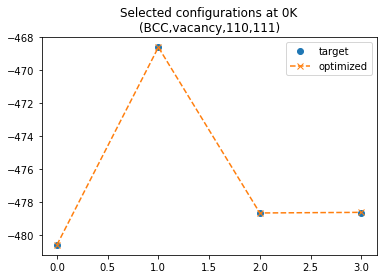

In [842]:
sopi=[-480.59780426946804, -468.61009716387832, -478.66198218651613, -478.62490818163315]
star=[-480.60000000002037, -468.60958975147514, -478.6412966408825, -478.64398486557184]
plt.title('Selected configurations at 0K\n(BCC,vacancy,110,111)')
plt.plot(star, 'o', label='target')
plt.plot([o for o in sopi], 'x--', label='optimized')
plt.legend()

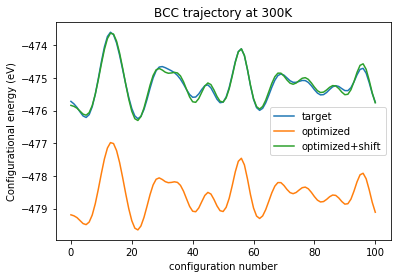

In [853]:
opi = [-479.19152696475197, -479.22232955733739, -479.27759711915547, -479.36827814396628, -479.45953647684894, -479.49198266162182, -479.41332115674476, -479.19830356622964, -478.85247928179092, -478.40970092484122, -477.92774273687451, -477.48096093816645, -477.1460768614354, -476.98096344780197, -477.01021879011506, -477.22600598913482, -477.59205190455066, -478.05163209608122, -478.54207169068002, -479.00138317248525, -479.37125860575668, -479.59956392150156, -479.6537557300627, -479.53353183913521, -479.27277874613935, -478.92904543415852, -478.57267664230346, -478.27782844697361, -478.10280536780351, -478.06106580274343, -478.10922715699832, -478.17567663332528, -478.20808829701411, -478.19958725944593, -478.18083421298678, -478.19840258108036, -478.29063178357751, -478.46899275063925, -478.70499910768871, -478.9341102532851, -479.08155908169903, -479.0977017482852, -478.98281426305891, -478.78704388605149, -478.59779923375822, -478.50547341024031, -478.55556577011117, -478.72072112567946, -478.92001546218319, -479.06508803163035, -479.09030721402945, -478.96285017251728, -478.6854504128446, -478.29704741399286, -477.87806851974477, -477.55371848816611, -477.46083591157981, -477.66313522631481, -478.08854807288895, -478.57697914926808, -478.9829768683353, -479.22971842734802, -479.30348762322296, -479.22502705143165, -479.03346429005626, -478.77901293797498, -478.51974215920455, -478.31376481686596, -478.20478511741652, -478.20619847557072, -478.29449511682969, -478.41592690837609, -478.51188341231983, -478.5442751885758, -478.50793372528096, -478.43066686200876, -478.36112163330176, -478.34333387824734, -478.39514566416256, -478.50366214179871, -478.633461392649, -478.74282047021762, -478.79785370392693, -478.78571139114695, -478.7201814633774, -478.63825303311052, -478.58587137027826, -478.5970283258543, -478.67488568443025, -478.78471795270815, -478.86465520244661, -478.8516556062944, -478.71286391470926, -478.46653909994859, -478.18262405098835, -477.96603676901685, -477.9197194994195, -478.08858704693699, -478.42411182991685, -478.80806101606385, -479.11270208182441]
tar = [-475.71991971456737, -475.79645176616032, -475.90415351967386, -476.04189787899668, -476.16565993455879, -476.21095316734863, -476.1241782020079, -475.88293801860709, -475.50065150904993, -475.02128303752397, -474.51205305203621, -474.05533657119668, -473.7332001724717, -473.60287323154625, -473.67854785207601, -473.93209792685229, -474.30776553644682, -474.74331495248771, -475.1868275115703, -475.59783877905284, -475.937498500527, -476.16527638990374, -476.24903143451957, -476.17795948559069, -475.96841418402619, -475.66178202249284, -475.3178276624094, -475.00446176879632, -474.77986720459012, -474.66920076948009, -474.65354428454884, -474.68764696676226, -474.7338515092124, -474.78134628004045, -474.84004126148648, -474.92421767457563, -475.04250928710098, -475.19365321815712, -475.36093391531904, -475.50878880494565, -475.59332767380693, -475.58577569504268, -475.4914399072004, -475.35318560632004, -475.2390255000646, -475.21441578552185, -475.30556743183115, -475.47809026838513, -475.6552089737088, -475.76006931322627, -475.74310913027148, -475.58544956645346, -475.29544152710878, -474.91028666426428, -474.50435113848653, -474.19391196656215, -474.10986984171905, -474.31711591636122, -474.74762306074263, -475.24315755059069, -475.65694247568899, -475.91105977201369, -475.99390867713373, -475.93177349491452, -475.76441959911608, -475.53484140377259, -475.28853473052732, -475.07266808558779, -474.92889653806924, -474.87964227839257, -474.916534400807, -475.0020037633949, -475.0873114902497, -475.13587403623387, -475.1372608650272, -475.10741540575691, -475.07840588058752, -475.08268106302421, -475.13820891008072, -475.24000987231557, -475.36146086400549, -475.46551043994259, -475.52061787094863, -475.51235036853177, -475.44792684394633, -475.35502128710505, -475.27331471641082, -475.23830167694541, -475.26309316362313, -475.32851983628643, -475.38865375638125, -475.39062494989776, -475.30017875906196, -475.12213949221768, -474.90689762090915, -474.73945243089111, -474.70790027282783, -474.85520331535372, -475.1452367973543, -475.47855531114328, -475.7447880734253]
plt.title('BCC trajectory at 300K')
plt.plot(tar, label='target')
plt.plot([o for o in opi], label='optimized')
plt.plot([o+3.35 for o in opi], label='optimized+shift')
plt.xlabel('configuration number')
plt.ylabel('Configurational energy (eV)')
plt.legend()

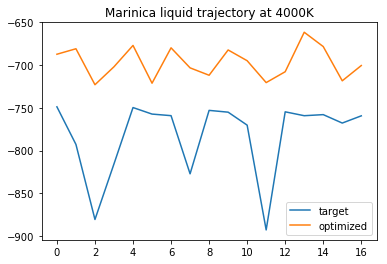

In [794]:
opi = [-687.43679309758932, -681.02065659051198, -723.06869068839956, -702.07512393100683, -677.14901901072199, -721.2954164009717, -679.9446033722586, -703.36129057270716, -711.99875954826791, -682.43179098463463, -695.00250693975659, -720.59455339651186, -707.89173038466686, -661.71919579536791, -678.46032593121754, -718.49788355494047, -700.64889272141852]
tar = [-748.92596900000001, -792.87149650000003, -880.63634160000004, -815.61296990000005, -749.77039820000005, -757.39729380000006, -759.24655580000001, -827.23146020000001, -753.07149030000005, -755.16599650000001, -770.33142569999995, -892.83260970000003, -754.76169289999996, -759.30482040000004, -758.04525130000002, -767.8930345, -759.45380439999997]
plt.title('Marinica liquid trajectory at 4000K')
plt.plot(tar, label='target')
plt.plot([o for o in opi], label='optimized')
plt.legend()

In [757]:
# Gauge conversion perameters
C = 1.848055990
S = 2.232322602e-1

# electronic density function (cubic splines)
rho = lambda r, a, k: sum([c*(p - r)**3 for c, p in zip(a, k) if r < p])

# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

#Fc = lambda d, a: a[0] + a[1]*d + a[2]*d**2 + a[3]*d**3
#Fe = lambda d, a: F(d/S, a) + C/S*d
#Fa = lambda d, a1, a2: Fe(d, a1) if d < 1.359141225 else Fc(d, a2)

# pair potential function (same spline form as electronic density)
V = rho

V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Embedding function. Parameters: electronic density (d), coefficients for 1/2, 1, and 2 powers of density
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

# Cohesive potential (cubic splines - same form as V)
phi = V

In [758]:
# electronic density parameters
rho_re_a = [3.704045964e-3]
rho_re_r = [5.46]

# embeding function parameters
F_re_a = [-7.046791948, 1.23658472, 1.143405627]
#F_re_a = [-7.046791948, 0, 1.143405627]

# pair potential
V_re_a = [6.726805309, 3.217593889, -6.545857587e-1, 1.453229484e-1, -2.063629464e-1, 6.114909116e-2]
V_re_r = [2.7, 3.252, 3.804, 4.356, 4.908, 5.46]

In [759]:
# electronic density parameters
#rho_x_a = [3.704045964e-3]
rho_x_a = [1.0]
rho_x_r = [4.77]

# embeding function parameters
F_x_a = [-7.046791948, 1.23658472, 1.143405627]
#F_re_a = [-7.046791948, 0, 1.143405627]

#3.704045964e-3

# pair potential
V_x_a = [6.726805309, 3.217593889, -6.545857587e-1, 1.453229484e-1, -2.063629464e-1, 6.114909116e-2]
V_x_a = [x*2 for x in V_re_a]
#V_re_r = [2.7, 3.252, 3.804, 4.356, 4.908, 5.46]
V_x_r = [2.56, 2.73, 3.252, 3.804, 4.20, 4.77]
#[2.56, 2.73, 3.252, 3.804, 4.20, 4.77]

In [831]:
def utot_opt(x, pn, mn):
    u = 4*V(x, pn, V_x_r)
    d = 8*phi(x, rho_x_a, rho_x_r)
    u += F(d, mn)
    return u/8

def utot_re(x):
    u = 4*V(x, V_re_a, V_re_r)
    d = 8*phi(x, rho_re_a, rho_re_r)
    u += F(d, F_re_a)
    return u/8

In [832]:
pair_x = pars_in[2:]
many_x = [pars_in[0], 0.0, pars_in[1]]

In [833]:
pair_y = params_uopt[2:]
many_y = [params_uopt[0], 0.0, params_uopt[1]]

pair_z = params_fopt[2:]
many_z = [params_fopt[0], 0.0, params_fopt[1]]
many_y

[-1.1649496773796486, 0.0, 6.2074554886143939e-05]

In [834]:
# Cohesive potential parameters
rho_w_a = [-0.420429e1, 0.518217702, 0.5627208e-1, 0.344164179e-1]
rho_w_r = [2.5, 3.1, 3.5, 4.9]

# Embedding function parameters
F_w_a = [-5.946454, 0.0, -0.049477] # Original Marinica
Fc_w_a = [-5.524855802, 2.317313103e-1, -3.665345949e-2, 8.989367404e-3] # Bonny's correction

# Pair potential parameters
arr = np.array([
(1,  0.960851701343041e2, 2.5648975),
(2, -0.184410923895214e3, 2.6297950),
(3,  0.935784079613550e2, 2.6946925),
(4, -0.798358265041677e1, 2.8663175),
(5,  0.747034092936229e1, 2.9730450),
(6, -0.152756043708453e1, 3.0797725),
(7,  0.125205932634393e1, 3.5164725),
(8,  0.163082162159425e1, 3.8464450),
(9, -0.141854775352260e1, 4.1764175),
(10,-0.819936046256149e0, 4.7008450),
(11, 0.198013514305908e1, 4.8953000),
(12,-0.696430179520267e0, 5.0897550),
(13, 0.304546909722160e-1,5.3429525),
(14,-0.163131143161660e1, 5.4016950),
(15, 0.138409896486177e1, 5.4604375)])

V_w_a = arr[:,1]
V_w_r = arr[:,2]

In [835]:
# Gauge conversion perameters
C = 1.848055990
S = 2.232322602e-1

# Rescaled cohesive potential function
rho = lambda r: phi(r, rho_w_a, rho_w_r)*S

# Rescaled embedding function with Bonny's correction
Fe = lambda d, a: F(d/S, a) + C/S*d # rescaled potential
Fc = lambda d, a: a[0] + a[1]*d + a[2]*d**2 + a[3]*d**3 # correction
Fa = lambda d, a1, a2: Fe(d, a1) if d < 1.359141225 else Fc(d, a2) # rescaled + correction

# Rescaled pair potential function
V_pair = lambda r: 0.5*(V(r, V_w_a, V_w_r) - 2*C*rho(r)/S)

# Manybody potential for 8 NN
V_man = lambda x: Fa(rho(x)*8, F_w_a, Fc_w_a)/8
V_many = lambda d: Fa(d, F_w_a, Fc_w_a)

//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


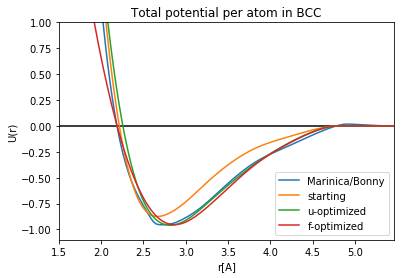

In [836]:
rcut = 5.46
r = np.linspace(0., rcut, 201)

pot = [utot_re(x) for x in r]
pot_start = [utot_opt(x, pair_x, many_x) for x in r]
pot_uopt = [utot_opt(x, pair_y, many_y) for x in r]
pot_fopt = [utot_opt(x, pair_z, many_z) for x in r]

plt.title('Total potential per atom in BCC')
pot_tot = [V_pair(x) + V_man(x) for x in r]
plt.plot(r, pot_tot, label='Marinica/Bonny')
#plt.plot(r, pot, label='original')
plt.plot(r, pot_start, label='starting')
plt.plot(r, pot_uopt, label='u-optimized')
plt.plot(r, pot_fopt, label='f-optimized')

plt.legend()
plt.hlines(0.0, 1.5, rcut)
#plt.hlines(-0.89, 1.5, rcut)

plt.axis([1.5, rcut, -1.1, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'U(r)')

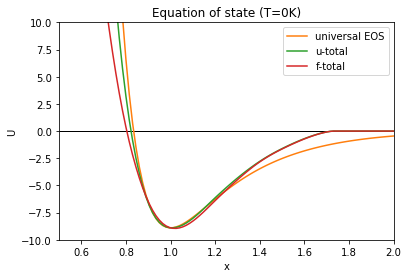

In [845]:
# Total pair potential
pos = targ_dict['dset0']['xyz'][0]
bx = targ_dict['dset0']['box'][0]
rr, rx = pair_dist(pos, bx)

plt.hist(rr[0], 50)
#r = np.linspace(0., rcut, 201)
ene = []
for a in np.linspace(0.5, 2.0, 101):
    z = a*rr
    u_pair = 0.5*np.sum([V(x, pair_y, V_x_r) for x in z.flatten() if x > 0.1])

    u_many = 0.0
    for i in range(z.shape[0]):
        #print(z[i])
        d = np.sum([phi(x, rho_x_a, rho_x_r) for x in z[i] if x > 0.1])
        #print('d',a, d)
        u_many += F(d, many_y)

    ene.append([a, u_pair, u_many, u_pair+u_many])

ene2 = []
for a in np.linspace(0.5, 2.0, 101):
    z = a*rr
    u_pair = 0.5*np.sum([V(x, pair_z, V_x_r) for x in z.flatten() if x > 0.1])

    u_many = 0.0
    for i in range(z.shape[0]):
        #print(z[i])
        d = np.sum([phi(x, rho_x_a, rho_x_r) for x in z[i] if x > 0.1])
        u_many += F(d, many_z)

    ene2.append([a, u_pair, u_many, u_pair+u_many])
    
#print(ene)
ene = np.array(ene)
ene2 = np.array(ene2)

#plt.plot(ene[:,0], ene[:,1]/54, label='pair')
#plt.plot(ene[:,0], ene[:,2]/54, label='manybody')
plt.title('Equation of state (T=0K)')
plt.plot(ene[:,0], [eos(x) for x in ene[:,0]], label='universal EOS')
plt.plot(ene[:,0], ene[:,3]/54, label='u-total')
plt.plot(ene2[:,0], ene2[:,3]/54, label='f-total')
plt.hlines(0.0,0.5,2.0,lw=1)
plt.legend()
plt.xlim(0.5, 2.0)
plt.ylim(-10,10)
plt.xlabel('x')
plt.ylabel(r'U')

In [804]:
# Ranges of densities and separations
rhomax = 10.0
nrho = 5000
drho = rhomax/nrho

nr = 5000
#rcut = 5.46
rcut = 4.77
dr = rcut/nr

ri = 1.0
ro = 2.0

# W properties
na = 74
ma = 183.84
lc = 3.1653
alat = 'bcc'

# System composition
n_el = 1
el_name = ['W']

In [825]:
# Cubic spline function for pair potentials and electronic density
f_spline = lambda r, aa, kk: sum([a*(rk - r)**3 for a, rk in zip(aa, kk) if r < rk and r > 0.01])

# Functional form for the embedding potential
f_embed = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

# prepare lists of values
dens = np.linspace(0., rhomax-drho, nrho, endpoint=True)
r = np.linspace(0., rcut-dr, nr, endpoint=True)

#fembd = [f_embed(d, many_y) for d in dens] # Re
Fe = lambda d, a: f_embed(d/S, a) - C/S*d # rescaled potential
#fembd = [F(d, many_y) for d in dens] # W
fembd = [Fe(d, many_z) for d in dens] # W


#edens = [f_spline(x, rho_x_a, rho_x_r) for x in r] # Re
#edens = np.array([f_spline(x, rho_x_a, rho_x_r) for x in r]) # W
edens = np.array([f_spline(x, rho_x_a, rho_x_r)*S for x in r]) # W

# Pair potential

# 1. Cubic spline for r > r_o
#f_outer = [f_spline(x, pair_y, V_x_r) for i, x in enumerate(r)]
f_outer = [f_spline(x, pair_z, V_x_r) + 2*C*edens[i]/S for i, x in enumerate(r)]

# 2. Repulsive core for r < r_i (precalculate up to r_o)
f_inner = [0.0] + [u_core(x) for x in r[1:]]

# 3. Transition region for r_i < r < r_o
fpair = [x*u_trans(x, f_inner[i], f_outer[i]) for i, x in enumerate(r)]
#fpair = [x*f_outer[i] for i, x in enumerate(r)]

In [826]:
# LAMMPS format
with open(os.path.join(pot_path, 'W_lv.eam.fs'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    fo.write(f"{n_el:5d} ")
    for i in range(n_el):
        fo.write(f"{el_name[i]:2}")
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    
    # atomic number, mass, lattice size, lattice type
    fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))